In [3]:
!pip install transformers
!pip install fast-bert
import torch
from transformers import BertTokenizer, BertForSequenceClassification
model_name = 'bert-base-uncased'  # Choose a suitable pre-trained model name
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Adjust num_labels based on your classification task
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 816.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for seqeval: file

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset, Dataset
import pandas as pd

# Upload the file
#uploaded = files.upload()

# Assuming the uploaded file is named 'train.tsv' after upload
train_path = '/kaggle/input/hausa-tweeter-sentiment-analysis/train.tsv'

# Pre-process data using pandas (optional) for handling TSV format
df = pd.read_csv(train_path, sep='\t')  # Read TSV with tab separator

# Print the column names to debug
print(df.columns)

2024-07-02 11:05:11.861152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 11:05:11.861257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 11:05:11.954581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Index(['tweet', 'label'], dtype='object')


In [5]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/kaggle/input/hausa-tweeter-sentiment-analysis/train.tsv', sep='\t')

# Check the label distribution
print(data['label'].value_counts())

label
neutral     4912
positive    4687
negative    4573
Name: count, dtype: int64


In [39]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import json

# Load the dataset
data = pd.read_csv('/kaggle/input/hausa-tweeter-sentiment-analysis/train.tsv', sep='\t')

# Encode the labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['tweet'], padding="max_length", truncation=True)

# Create dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Split data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data['tweet'], data['label'], test_size=0.2)

# Tokenize the datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Create datasets
train_dataset = CustomDataset(train_encodings, train_labels.tolist())
val_dataset = CustomDataset(val_encodings, val_labels.tolist())

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_strategy="steps",
    save_strategy="no"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
train_output = trainer.train()

# Evaluate the model
eval_output = trainer.evaluate()

# Extract the training loss
train_loss = train_output.training_loss

# Extract the evaluation loss
eval_loss = eval_output['eval_loss']

# Assuming evaluation accuracy is present, if not, this should be adapted
eval_accuracy = eval_output.get('eval_accuracy', None)

# Parse the logs to extract steps and losses
def parse_log_file(log_file):
    steps = []
    losses = []
    with open(log_file, 'r') as f:
        for line in f:
            log_entry = json.loads(line)
            if 'loss' in log_entry:
                steps.append(log_entry['step'])
                losses.append(log_entry['loss'])
    return steps, losses

log_dir = './logs'
log_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events.out.tfevents.' in f]

all_steps = []
all_losses = []
for log_file in log_files:
    steps, losses = parse_log_file(log_file)
    all_steps.extend(steps)
    all_losses.extend(losses)

# Plot the training loss over steps
plt.figure(figsize=(10, 5))
plt.plot(all_steps, all_losses, label='Training Loss')
plt.axhline(y=eval_loss, color='r', linestyle='-', label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "

Step,Training Loss,Validation Loss
500,0.409500,0.719610
1000,0.083800,1.235497
1500,0.052700,1.503612
2000,0.026800,1.935356
2500,0.100100,2.013814
3000,0.006800,2.302246
3500,0.000200,2.389350
4000,0.005600,2.585376
4500,0.000200,2.632552
5000,0.000900,2.608471


***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128
***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2835
  Batch size = 128


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfe in position 8: invalid start byte

In [32]:
!pip install tensorboard

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [40]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Function to parse TensorBoard log files
def parse_tensorboard_logs(log_dir):
    steps = []
    losses = []
    for event in tf.compat.v1.train.summary_iterator(log_dir):
        for value in event.summary.value:
            if value.tag == 'loss':  # Adjust this tag based on your logging configuration
                steps.append(event.step)
                losses.append(value.simple_value)
    return steps, losses

# Get the list of log files (events files)
log_files = [os.path.join(training_args.logging_dir, f) for f in os.listdir(training_args.logging_dir) if 'events.out.tfevents.' in f]

# Parse each log file and accumulate steps and losses
all_steps = []
all_losses = []
for log_file in log_files:
    steps, losses = parse_tensorboard_logs(log_file)
    all_steps.extend(steps)
    all_losses.extend(losses)

# Debug: Print the first few entries to verify
print(f"Steps: {all_steps[:10]}")
print(f"Losses: {all_losses[:10]}")

# Check if the lists are not empty and have the same length
if not all_steps or not all_losses or len(all_steps) != len(all_losses):
    print("No valid log entries found or mismatch in lengths of steps and losses.")
else:
    # Sort by steps to ensure the correct order
    sorted_indices = sorted(range(len(all_steps)), key=lambda i: all_steps[i])
    all_steps = [all_steps[i] for i in sorted_indices]
    all_losses = [all_losses[i] for i in sorted_indices]

    # Plot the training loss over steps
    plt.figure(figsize=(10, 5))
    plt.plot(all_steps, all_losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()

Steps: []
Losses: []
No valid log entries found or mismatch in lengths of steps and losses.


In [41]:
# Train the model
#train_output = trainer.train()

# Evaluate the model
#eval_output = trainer.evaluate()

# Inspect the outputs
print("Train Output:", train_output)
print("Train Output Type:", type(train_output))
print("Train Output Attributes:", dir(train_output))

print("Eval Output:", eval_output)
print("Eval Output Type:", type(eval_output))
print("Eval Output Attributes:", dir(eval_output))

Train Output: TrainOutput(global_step=5340, training_loss=0.10108565489244802, metrics={'train_runtime': 6245.8476, 'train_samples_per_second': 54.454, 'train_steps_per_second': 0.855, 'total_flos': 3.460649588220132e+16, 'train_loss': 0.10108565489244802, 'epoch': 30.0})
Train Output Type: <class 'transformers.trainer_utils.TrainOutput'>
Train Output Attributes: ['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'global_step', 'index', 'metrics', 'training_loss'

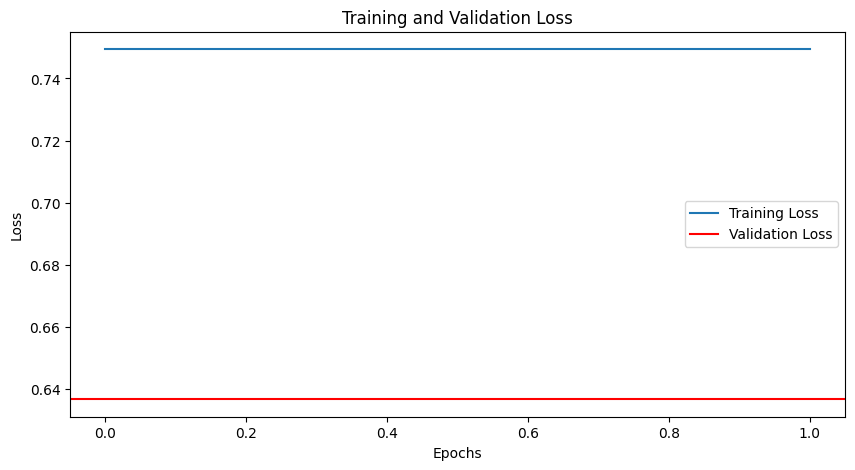

In [12]:
import matplotlib.pyplot as plt

# Assuming the training and evaluation outputs are available as train_output and eval_output

# Extract the training loss
train_loss = train_output.training_loss

# Extract the evaluation loss
eval_loss = eval_output['eval_loss']

# Assuming evaluation accuracy is present, if not, this should be adapted
eval_accuracy = eval_output.get('eval_accuracy', None)

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(training_args.num_train_epochs), [train_loss] * training_args.num_train_epochs, label='Training Loss')
plt.axhline(y=eval_loss, color='r', linestyle='-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy if available
if eval_accuracy is not None:
    plt.figure(figsize=(10, 5))
    plt.axhline(y=eval_accuracy, color='r', linestyle='-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

                Metric     Value
0        Training Loss  0.101086
1      Validation Loss  2.619291
2  Validation Accuracy       N/A


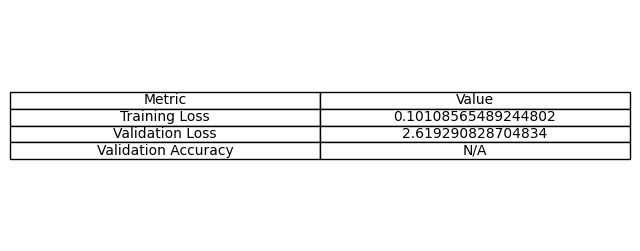

In [42]:
import pandas as pd

# Extract relevant metrics
train_loss = train_output.training_loss
eval_loss = eval_output['eval_loss']
eval_accuracy = eval_output.get('eval_accuracy', 'N/A')  # Use 'N/A' if accuracy is not available

# Create a dictionary with the metrics
metrics = {
    'Metric': ['Training Loss', 'Validation Loss', 'Validation Accuracy'],
    'Value': [train_loss, eval_loss, eval_accuracy]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table
print(metrics_df)

# Optionally, display the table using Matplotlib
fig, ax = plt.subplots(figsize=(8, 3))  # set size frame
ax.axis('tight')
ax.axis('off')
ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

plt.show()

                 Metric     Value
0         Training Loss  0.166686
1       Validation Loss  2.086118
2   Validation Accuracy       N/A
3  Validation Precision       N/A
4     Validation Recall       N/A
5         Validation F1       N/A


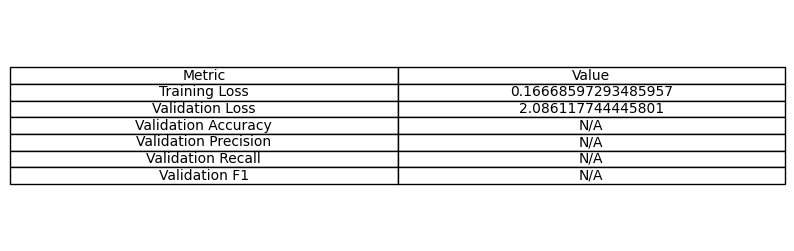

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract metrics
train_loss = train_output.training_loss
eval_loss = eval_output['eval_loss']
eval_accuracy = eval_output.get('eval_accuracy', 'N/A')
eval_precision = eval_output.get('eval_precision', 'N/A')
eval_recall = eval_output.get('eval_recall', 'N/A')
eval_f1 = eval_output.get('eval_f1', 'N/A')

# Create a dictionary with the metrics
metrics = {
    'Metric': ['Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1'],
    'Value': [train_loss, eval_loss, eval_accuracy, eval_precision, eval_recall, eval_f1]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table
print(metrics_df)

# Optionally, display the table using Matplotlib
fig, ax = plt.subplots(figsize=(10, 3))  # set size frame
ax.axis('tight')
ax.axis('off')
ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

plt.show()

# Optionally plot the confusion matrix if needed
if 'eval_accuracy' in eval_output:
    preds = trainer.predict(val_dataset)
    cm = confusion_matrix(preds.label_ids, preds.predictions.argmax(-1))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [1]:
# Extract training metrics
global_step = train_output.global_step
training_loss = train_output.training_loss
train_runtime = train_output.metrics['train_runtime']
train_samples_per_second = train_output.metrics['train_samples_per_second']
train_steps_per_second = train_output.metrics['train_steps_per_second']
total_flos = train_output.metrics['total_flos']
train_loss = train_output.metrics['train_loss']
train_epoch = train_output.metrics['epoch']

# Extract evaluation metrics
eval_loss = eval_output['eval_loss']
eval_runtime = eval_output['eval_runtime']
eval_samples_per_second = eval_output['eval_samples_per_second']
eval_steps_per_second = eval_output['eval_steps_per_second']
eval_epoch = eval_output['epoch']

NameError: name 'train_output' is not defined

In [2]:
# Extract training metrics
global_step = train_output.global_step
training_loss = train_output.training_loss
train_runtime = train_output.metrics['train_runtime']
train_samples_per_second = train_output.metrics['train_samples_per_second']
train_steps_per_second = train_output.metrics['train_steps_per_second']
total_flos = train_output.metrics['total_flos']
train_loss = train_output.metrics['train_loss']
train_epoch = train_output.metrics['epoch']

# Extract evaluation metrics
eval_loss = eval_output['eval_loss']
eval_runtime = eval_output['eval_runtime']
eval_samples_per_second = eval_output['eval_samples_per_second']
eval_steps_per_second = eval_output['eval_steps_per_second']
eval_epoch = eval_output['epoch']

NameError: name 'train_output' is not defined